In [1]:
# to load libraries on gioia's computer
import sys
sys.version
sys.path.append('/Users/maggiori/anaconda/envs/py35/lib/python3.5/site-packages')
sys.path.append('/Users/maggiori/anaconda/envs/py35')

In [2]:
from sklearn.neighbors import KernelDensity

from scipy.stats.distributions import norm
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.2)

## Shared Variables

In [3]:
# draw points from a bimodal distribution in 1D
N = 100000

np.random.seed(0) # for consistency across runs
x = np.concatenate([norm(-1, 1.).rvs(int(0.8 * N)),
                    norm(1, 0.3).rvs(int(0.2 * N))])

In [4]:
# the grid we'll use for plotting
x_grid = np.linspace(-4.5, 3.5, 1000)

# the real PDF of the bimodal distribution
pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) +
            0.2 * norm(1, 0.3).pdf(x_grid))

In [5]:
kernel = 'gaussian'
bandwidth = 0.2

## Naive Python Implementation

In [6]:
def gaussian(x):
    '''
    Returns the Gaussian function for a given input variable.
    
    Parameters
    ----------
    x : float
        the x-value at which to evaluate the Gaussian function
        
    Returns
    ----------
    gaussian : float
        the result of evaluating the Gaussian function at x
    '''
    return np.exp(-1.0 * (x**2) / 2) * (1.0 / np.sqrt(2.0 * np.pi))

In [7]:
def naive_kde(x, x_grid, h):
    '''
    Calcalates the KDE PDF estimate, based on a Gaussian kernel.
    
    Parameters
    ----------
    x : list
        iid random variables that are used to calculate the KDE estimate
    x_grid : list
        values along which to calculate the KDE estimate
    h : float
        bandwidth parameter for the KDE estimate
        
    Returns
    ----------
    estimates: list
        KDE estimates for all values of x_grid
    '''
    global N # number of iid random variables
    estimates = [0] * len(x_grid)
    
    for j, gridpt in enumerate(x_grid):
        for i in range(int(N)):
            val_in_sum = gaussian((x[i] - gridpt) / h)
            estimates[j] += val_in_sum
        
        estimates[j] = estimates[j] / (N * h)
    
    return estimates

Time to complete model: 314.68 seconds


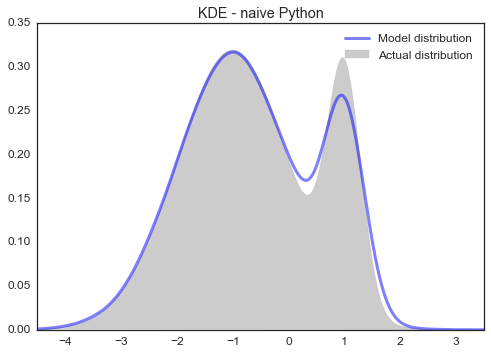

In [8]:
# Note: we are making a point of converting everything to lists
# before running the KDE function, in order to observe the performance
# of a "pure" Python implementation.

timer = time.time()
pdf = naive_kde(list(x), list(x_grid), bandwidth)
print('Time to complete model: {:.2f} seconds'.format(time.time() - timer))

plt.plot(x_grid, pdf, color='blue', alpha=0.5, lw=3, label='Model distribution')
plt.fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4, label='Actual distribution')
plt.title('KDE - naive Python')
plt.legend(loc='best')
plt.xlim(-4.5, 3.5)
plt.show()

## Vectorized Python Implementation

In [9]:
def vectorized_kde(x, x_grid, h):
    '''
    Calcalates the KDE PDF estimate, based on a Gaussian kernel.
    
    Parameters
    ----------
    x : numpy array
        iid random variables that are used to calculate the KDE estimate
    x_grid : numpy array
        values along which to calculate the KDE estimate
    h : float
        bandwidth parameter for the KDE estimate
        
    Returns
    ----------
    estimates: numpy array
        KDE estimates for all values of x_grid
    ''' 
    global N # number of iid random variables

    estimates = np.zeros(len(x_grid))
    
    for j, gridpt in enumerate(x_grid):
        val_in_sum = gaussian((x - gridpt)/h)  # returns vector of dim N
        estimates[j] = np.sum(val_in_sum) / (N * h)
    
    return estimates

Time to complete model: 1.45 seconds


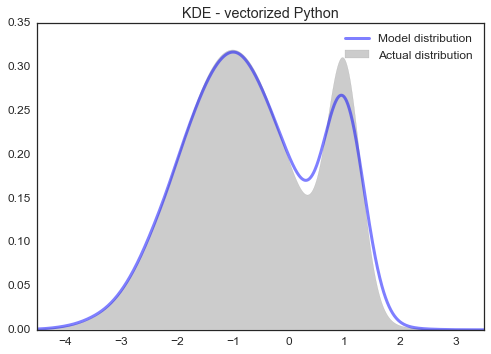

In [10]:
timer = time.time()
pdf = vectorized_kde(x, x_grid, bandwidth)
print('Time to complete model: {:.2f} seconds'.format(time.time() - timer))

plt.plot(x_grid, pdf, color='blue', alpha=0.5, lw=3, label='Model distribution')
plt.fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4, label='Actual distribution')
plt.title('KDE - vectorized Python')
plt.legend(loc='best')
plt.xlim(-4.5, 3.5)
plt.show()

## Scikit-Learn Implementation

In [11]:
def kde_sklearn(x, x_grid, bandwidth, **kwargs):
    '''
    Kernel Density Estimation with Scikit-learn
    Source: http://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
    '''
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

Time to complete model: 6.10 seconds


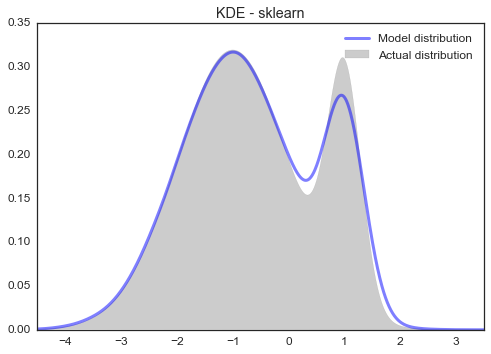

In [12]:
timer = time.time()
pdf = kde_sklearn(x, x_grid, bandwidth=bandwidth, kernel=kernel)
print('Time to complete model: {:.2f} seconds'.format(time.time() - timer))

plt.plot(x_grid, pdf, color='blue', alpha=0.5, lw=3, label='Model distribution')
plt.fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4, label='Actual distribution')
plt.title('KDE - sklearn')
plt.legend(loc='best')
plt.xlim(-4.5, 3.5)
plt.show()

## Comparing Execution Time

In [13]:
timer_sk = []
timer_pp = []
timer_np = []

test_n = [1e1, 1e2, 1e3, 1e4, 1e5]

np.random.seed(0) # for consistency across runs

for N in test_n:
    
    # draw random data points
    x = np.concatenate([norm(-1, 1.).rvs(int(0.8 * N)),
                        norm(1, 0.3).rvs(int(0.2 * N))])
    
    # sklearn
    timer = time.time()
    kde_sklearn(x, x_grid, bandwidth=bandwidth, kernel=kernel);
    timer_sk.append(time.time() - timer)
    
    # pure python
    timer = time.time()
    naive_kde(list(x), list(x_grid), bandwidth);
    timer_pp.append(time.time() - timer)
    
    # numpy
    timer = time.time()
    vectorized_kde(x, x_grid, bandwidth);
    timer_np.append(time.time() - timer)

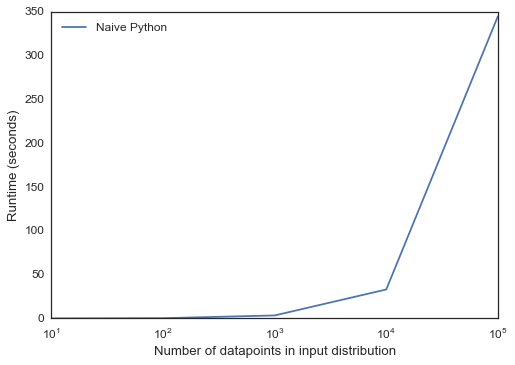

In [14]:
plt.plot(test_n, timer_pp, label='Naive Python')
plt.legend(loc='best')
plt.xlabel('Number of datapoints in input distribution')
plt.ylabel('Runtime (seconds)')
plt.xscale('log')
plt.plot();

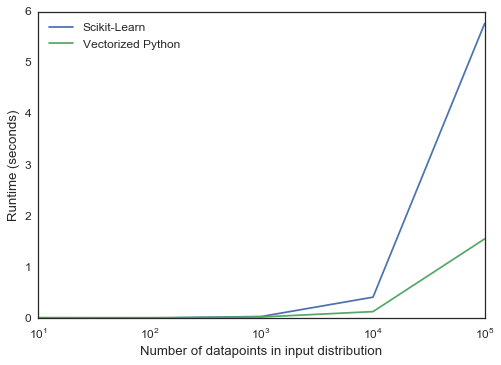

In [15]:
plt.plot(test_n, timer_sk, label='Scikit-Learn')
plt.plot(test_n, timer_np, label='Vectorized Python')
plt.legend(loc='best')
plt.xlabel('Number of datapoints in input distribution')
plt.ylabel('Runtime (seconds)')
plt.xscale('log')
plt.plot();